In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import the necessary packages
from imutils import contours
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

In [3]:
# define a dictionary that maps the first digit of a credit card
# number to the credit card type
FIRST_NUMBER = {
    "3": "American Express",
    "4": "Visa",
    "5": "MasterCard",
    "6": "Discover Card"
}

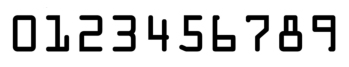

In [4]:
# load the reference OCR-A image from disk, convert it to grayscale,
# and threshold it, such that the digits appear as *white* on a
# *black* background
# and invert it, such that the digits appear as *white* on a *black*
ref = cv2.imread("ocr_a_reference.png")
plt.figure()
plt.axis("off")
plt.imshow(ref)

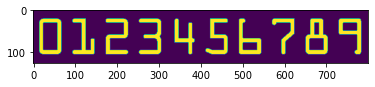

In [5]:
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
ref = cv2.threshold(ref, 10, 255, cv2.THRESH_BINARY_INV)[1]
plt.imshow(ref)

In [6]:
# find contours in the OCR-A image (i.e,. the outlines of the digits)
# sort them from left to right, and initialize a dictionary to map
# digit name to the ROI
refCnts = cv2.findContours(ref.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
refCnts = refCnts[1] if imutils.is_cv3() else refCnts[0]
refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]

In [7]:
digits = {}

In [8]:
# loop over the OCR-A reference contours
for (i, c) in enumerate(refCnts):
    # compute the bounding box for the digit, extract it, and resize
    # it to a fixed size
    (x, y, w, h) = cv2.boundingRect(c)
    roi = ref[y:(y + h), x:(x + w)]
    roi2 = cv2.resize(roi, (57, 88))
    print(digits)
    # update the digits dictionary, mapping the digit name to the ROI
    digits[i] = roi

{}
{0: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}
{0: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 1: array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0, 255, ...,   0,   0,   0],
       [  0, 255, 255, ...,   0,   0,   0],
       ...,
       [  0, 255, 255, ..., 255, 255, 255],
       [  0, 255, 255, ..., 255, 255,   0],
       [  0,   0,   0, ..., 255,   0,   0]], dtype=uint8)}
{0: array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 1: array([[  0,   0,   0, ...,   0

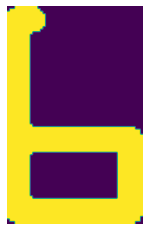

In [9]:
plt.figure()
plt.axis("off")
plt.imshow(digits[6])

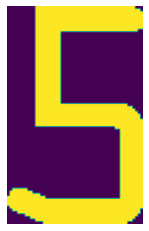

In [10]:
plt.figure()
plt.axis("off")
plt.imshow(digits[5])

In [35]:
# initialize a rectangular (wider than it is tall) and square
# structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

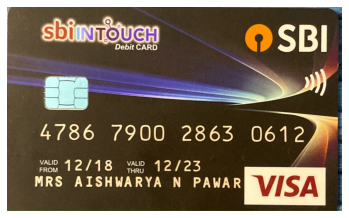

In [117]:
# load the input image, resize it, and convert it to grayscale
image = cv2.imread("test33.png")
plt.figure()
plt.axis("off")
plt.imshow(image)

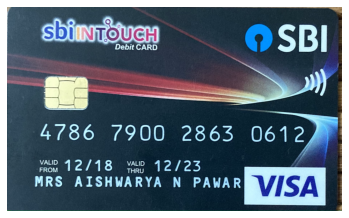

In [118]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
og = image.copy()
plt.figure()
plt.axis("off")
plt.imshow(image)

6.236263736263736


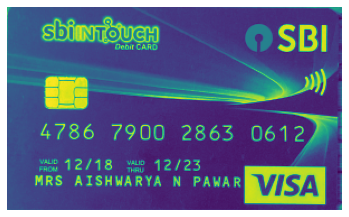

In [119]:
image = imutils.resize(image, width=300)
# print(image.shape,og.shape)
print(og.shape[0]/image.shape[0])

gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.figure()
plt.axis("off")
plt.imshow(gray)

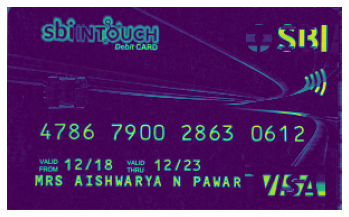

In [120]:
# apply a tophat (whitehat) morphological operator to find light
# regions against a dark background (i.e., the credit card numbers)
tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, rectKernel)
plt.figure()
plt.axis("off")
plt.imshow(tophat)

In [121]:
# compute the Scharr gradient of the tophat image, then scale
# the rest back into the range [0, 255]
gradX = cv2.Sobel(tophat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
gradX = np.absolute(gradX)
(minVal, maxVal) = (np.min(gradX), np.max(gradX))
gradX = (255 * ((gradX - minVal) / (maxVal - minVal)))
gradX = gradX.astype("uint8")

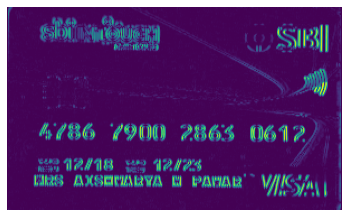

In [122]:
plt.figure()
plt.axis("off")
plt.imshow(gradX)

In [123]:
# apply a closing operation using the rectangular kernel to help
# cloes gaps in between credit card number digits, then apply
# Otsu's thresholding method to binarize the image
gradX = cv2.morphologyEx(gradX, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(gradX, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

In [124]:
# apply a second closing operation to the binary image, again
# to help close gaps between credit card number regions
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)

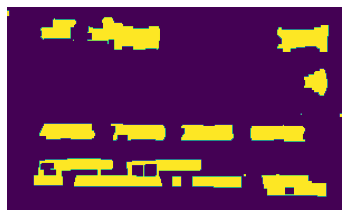

In [125]:
plt.figure()
plt.axis("off")
plt.imshow(thresh)

In [126]:
# find contours in the thresholded image, then initialize the
# list of digit locations
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
                        cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1] if imutils.is_cv3() else cnts[0]



# cnts = cnts[0] if imutils.is_cv2() else cnts[1]

In [127]:
locs = []

In [128]:
import pytesseract
# loop over the contours
results = []
for (i, c) in enumerate(cnts):
    # compute the bounding box of the contour, then use the
    # bounding box coordinates to derive the aspect ratio
    (x, y, w, h) = cv2.boundingRect(c)
    x = int(x*6.2)
    y = int(y*6.2)
    w = int(w*6.2)
    h = int(h*6.2)
#     cv2.rectangle(og, (x,y),
#               ((x+w),(y+h)), (0, 0, 255), 2)
#     plt.imshow(og)

	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
    startX = x
    startY = y
    endX = x+w
    endY = y+h

    #extract the region of interest
    r = og[startY:endY, startX:endX]
#     plt.imshow(r)
#     plt.show()
	#configuration setting to convert image to string.  
    configuration = ("-l eng --oem 1 --psm 8")
    ##This will recognize the text from the image of bounding box
    text = pytesseract.image_to_string(og, config=configuration)

    # append bbox coordinate and associated text to the list of results 
    results.append(text)

print(results)

['—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c', '—\n\x0c']


In [129]:
# sort the digit locations from left-to-right, then initialize the
# list of classified digits
locs = sorted(locs, key=lambda x:x[0])

In [110]:
locs

[]

In [111]:
output = []

In [601]:
# loop over the 4 groupings of 4 digits
import pytesseract
from pytesseract import Output

for (i, (gX, gY, gW, gH)) in enumerate(locs):
    groupOutput = []
    group = gray[gY - 5:gY + gH + 5, gX - 5:gX + gW + 5]
    group = cv2.threshold(group, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
    digitCnts = cv2.findContours(group.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    
    digitCnts = digitCnts[1] if imutils.is_cv3() else digitCnts[0]

    digitCnts = contours.sort_contours(digitCnts,
    method="left-to-right")[0]

    for c in digitCnts:

        (x, y, w, h) = cv2.boundingRect(c)
        roi = group[y:y + h, x:x + w]
        roi = cv2.resize(roi, (57, 88))
                    
        scores = []
 
        for (digit, digitROI) in digits.items():

            result = cv2.matchTemplate(roi, digitROI,
                                       cv2.TM_CCOEFF)
            (_, score, _, _) = cv2.minMaxLoc(result)
            scores.append(score)
 
        groupOutput.append(str(np.argmax(scores)))
        cv2.rectangle(image, (gX - 5, gY - 5),
                      (gX + gW + 5, gY + gH + 5), (0, 0, 255), 2)
        cv2.putText(image, "".join(groupOutput), (gX, gY - 15),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 0, 255), 2) 
    output.extend(groupOutput)

In [602]:
print("Credit Card Type: {}".format(FIRST_NUMBER[output[0]]))

Credit Card Type: Visa


In [603]:
print("Credit Card #: {}".format("".join(output)))

Credit Card #: 478877002983089230


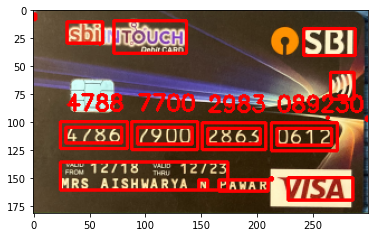

In [604]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))